# Preliminaries

In [1]:
import numpy as np
import scipy
from scipy import integrate
import matplotlib.pylab as plt
import pandas as pd
import itertools

In [2]:
from dissipationtheory.constants import ureg, epsilon0, qe, kb, Troom
from dissipationtheory.dissipation9a import CantileverModel, SampleModel1, SampleModel2, SampleModel3
from dissipationtheory.dissipation9b import SampleModel1Jit, SampleModel2Jit, SampleModel3Jit
from dissipationtheory.dissipation9b import integrand1jit, integrand2jit, integrand3jit
from dissipationtheory.dissipation9b import K_jit, Kp
from dissipationtheory.dissipation13e import rpI_jit, rpII_jit, rpIII_jit
from dissipationtheory.dissipation13e import KmatrixI_jit, KmatrixII_jit, KmatrixIII_jit

# Compare `K_jit` and `KmatrixIII_jit`

Look at Study 63, pick a challenging set of parameters, and verify that `K_jit` and `KmatrixIII_jit` yield comparable $K_n$ integrals to within a relative error less than $10^{-3}$.

In [3]:
cantilever = CantileverModel(
    f_c = ureg.Quantity(62, 'kHz'),
    k_c = ureg.Quantity(2.8, 'N/m'), 
    V_ts = ureg.Quantity(1, 'V'), 
    R = ureg.Quantity(60, 'nm'),
    angle = ureg.Quantity(20, 'degree'),
    L = ureg.Quantity(1000, 'nm'))

In [4]:
loc1_nm = np.array([  0,  0, 30], dtype=np.float64)
loc2_nm = np.array([  0, 30, 30], dtype=np.float64)

loc1_m = 1e-9 * loc1_nm
loc2_m = 1e-9 * loc2_nm

In [5]:
omega = 1e5 * 2 * np.pi

In [6]:
sample3 = SampleModel3(
    cantilever = cantilever,
    epsilon_s = ureg.Quantity(complex(100, 0), ''),
    sigma = ureg.Quantity(1e-6, 'S/m'),
    rho = ureg.Quantity(1e19, '1/m^3'),
    z_r = ureg.Quantity(1, 'nm'))

sample3_jit = SampleModel3Jit(**sample3.args())

params3_jit = {
    'integrand': integrand3jit, 
    'sample': sample3_jit, 
    'omega': omega, 
    'location1': loc1_m, 
    'location2': loc2_m}

In [7]:
K0, K1, K2 = K_jit(**params3_jit)
KnIII = np.array([K0, K1, K2])

In [8]:
j0s = scipy.special.jn_zeros(0, 100.0)
an, _ = scipy.integrate.newton_cotes(20, 1)

args = {
    "omega": omega,
    "omega0": params3_jit['sample'].omega0,
    "kD": params3_jit['sample'].kD,
    "es": params3_jit['sample'].epsilon_s,
    "sj": np.array([loc1_nm]),
    "rk": np.array([loc2_nm]),
    "j0s": j0s,
    "an": an}

In [9]:
K0, K1, K2 = KmatrixIII_jit(**args)
a = np.array([K0[0][0], K1[0][0], K2[0][0]])

In [10]:
def comparetwoK(a,b):
    
    for idx, (Ka, Kb) in enumerate(zip(a,b)):

        err_real = (Ka.real-Kb.real)/Ka.real        
        print('Re[K[{:d}]] {:+0.9e} vs {:+0.9e}, relative error = {:+3.2e}'.format(idx, Ka.real, Kb.real, err_real))

    print("")
    for idx, (Ka, Kb) in enumerate(zip(a,b)):
        err_imag = (Ka.imag-Kb.imag)/Ka.imag
        print('Im[K[{:d}]] {:+0.9e} vs {:+0.9e}, relative error = {:+3.2e}'.format(idx, Ka.imag, Kb.imag, err_imag))   

In [11]:
comparetwoK(KnIII,a)

Re[K[0]] +1.461201067e-02 vs +1.461201065e-02, relative error = +1.29e-09
Re[K[1]] +1.948263160e-04 vs +1.948263184e-04, relative error = -1.25e-08
Re[K[2]] +4.545940557e-06 vs +4.545941417e-06, relative error = -1.89e-07

Im[K[0]] -1.281215520e-07 vs -1.281296565e-07, relative error = -6.33e-05
Im[K[1]] -3.694413309e-10 vs -3.695350827e-10, relative error = -2.54e-04
Im[K[2]] -1.952840848e-12 vs -1.953324773e-12, relative error = -2.48e-04


My hypothesis is that the relative error in the two $K_n$ computations is the result of `K_jit` and `KmatrixIII_jit` using different numerical integration schemes.

# Compare integrands

Compare the $K_n$ integrals returned by `K_jit` (`dissipation9b.py`) to those obtained by numerically integrating `rpIII_jit`, `rpII_jit`, and `rpI_jit` (`dissipation13e`).  The computed integrals *should* be identical, because in both cases we are using the `scipy.integrate.quad_vec` function to perform the integration.  So this unit test demonstrates that we have coded the Fresnel coefficient $r_p$ correctly for the three classes of samples. 

Variables used by the integrands:

In [12]:
zjkref = loc1_nm[2] + loc2_nm[2]
x = np.sqrt((loc1_nm[0] - loc2_nm[0])**2 + (loc1_nm[1] - loc2_nm[1])**2) / zjkref

## Sample III

    cantilever | vacuum gap | semiconductor (semi-infinite)

In [13]:
def funcIII(y, x, omega, omega0, zr, kD, es):
    
    def t1(ell):
        return y**ell
    
    t2 = rpIII_jit(y, omega, omega0, zr, kD, es)
    t3 = scipy.special.j0(y * x) * np.exp(-y)
                 
    return np.array(
        [np.real(t1(0) * t2 * t3) / zr,
         np.imag(t1(0) * t2 * t3) / zr,
         np.real(t1(1) * t2 * t3) / zr**2,
         np.imag(t1(1) * t2 * t3) / zr**2,
         np.real(t1(2) * t2 * t3) / zr**3,
         np.imag(t1(2) * t2 * t3) / zr**3])

In [14]:
ansIII = integrate.quad_vec(funcIII, 
    0., np.inf,
    args=(x,
        omega,
        params3_jit['sample'].omega0,
        zjkref,
        params3_jit['sample'].kD,
        params3_jit['sample'].epsilon_s))[0] @ Kp

In [15]:
comparetwoK(KnIII, np.array([ansIII[0], ansIII[1], ansIII[2]]))

Re[K[0]] +1.461201067e-02 vs +1.461201067e-02, relative error = +6.85e-14
Re[K[1]] +1.948263160e-04 vs +1.948263160e-04, relative error = -5.83e-14
Re[K[2]] +4.545940557e-06 vs +4.545940557e-06, relative error = -3.09e-14

Im[K[0]] -1.281215520e-07 vs -1.281215485e-07, relative error = +2.72e-08
Im[K[1]] -3.694413309e-10 vs -3.694413112e-10, relative error = +5.34e-08
Im[K[2]] -1.952840848e-12 vs -1.952840814e-12, relative error = +1.72e-08


## Sample II

    cantilever | vacuum gap | dielectric | semiconductor (semi-infinite)

In [16]:
sample2 = SampleModel2(
    cantilever = cantilever,
    h_d = ureg.Quantity(20, 'nm'),
    epsilon_d = ureg.Quantity(complex(20, 0), ''),
    epsilon_s = ureg.Quantity(complex(100, 0), ''),
    sigma = ureg.Quantity(1e-6, 'S/m'),
    rho = ureg.Quantity(1e19, '1/m^3'),
    z_r = ureg.Quantity(1, 'nm'))

sample2_jit = SampleModel2Jit(**sample2.args())

params2_jit = {
    'integrand': integrand2jit, 
    'sample': sample2_jit, 
    'omega': omega, 
    'location1': loc1_m, 
    'location2': loc2_m}

In [17]:
K0, K1, K2 = K_jit(**params2_jit)
KnII = np.array([K0, K1, K2])

In [18]:
def funcII(y, x, omega, omega0, zr, kD, hd, ed, es):
    
    def t1(ell):
        return y**ell
    
    t2 = rpII_jit(y, omega, omega0, zr, kD, hd, ed, es)
    t3 = scipy.special.j0(y * x) * np.exp(-y)
                 
    return np.array(
        [np.real(t1(0) * t2 * t3) / zr,
         np.imag(t1(0) * t2 * t3) / zr,
         np.real(t1(1) * t2 * t3) / zr**2,
         np.imag(t1(1) * t2 * t3) / zr**2,
         np.real(t1(2) * t2 * t3) / zr**3,
         np.imag(t1(2) * t2 * t3) / zr**3])

To get this test to pass, take care to write `zr -> zr * 1e-9` in the `rpII_jit` function, to account for the fact that `zr` is in nanometers while `h_d` is in meters and `kD` is in 1/meters.  We can see this difference in the following computation.  Note that `zjkref` is passed for `zr` in the function call below.

In [19]:
(params2_jit['sample'].h_d, zjkref)

(2e-08, 60.0)

In [20]:
ansII = integrate.quad_vec(funcII, 
    0., np.inf,
    args=(x,
        omega,
        params2_jit['sample'].omega0,
        zjkref,
        params2_jit['sample'].kD,
        params2_jit['sample'].h_d,
        params2_jit['sample'].epsilon_d,  
        params2_jit['sample'].epsilon_s))[0] @ Kp

In [21]:
comparetwoK(KnII, np.array([ansII[0], ansII[1], ansII[2]]))

Re[K[0]] +1.429817843e-02 vs +1.429817843e-02, relative error = +8.08e-14
Re[K[1]] +1.879103217e-04 vs +1.879103217e-04, relative error = -5.19e-14
Re[K[2]] +4.346308861e-06 vs +4.346308861e-06, relative error = -3.04e-14

Im[K[0]] -1.239110040e-07 vs -1.239110007e-07, relative error = +2.64e-08
Im[K[1]] -3.459437682e-10 vs -3.459437487e-10, relative error = +5.64e-08
Im[K[2]] -1.749225416e-12 vs -1.749225376e-12, relative error = +2.29e-08


## Sample I

    cantilever | vacuum gap | semiconductor | dielectric (semi-infinite)

In [22]:
sample1 = SampleModel1(
    cantilever = cantilever,
    h_s = ureg.Quantity(20, 'nm'),
    epsilon_s = ureg.Quantity(complex(20, 0), ''),
    epsilon_d = ureg.Quantity(complex(100, 0), ''),
    sigma = ureg.Quantity(1e-6, 'S/m'),
    rho = ureg.Quantity(1e19, '1/m^3'),
    z_r = ureg.Quantity(1, 'nm'))

sample1_jit = SampleModel1Jit(**sample1.args())

params1_jit = {
    'integrand': integrand1jit, 
    'sample': sample1_jit, 
    'omega': omega, 
    'location1': loc1_m, 
    'location2': loc2_m}

In [23]:
K0, K1, K2 = K_jit(**params1_jit)
KnI = np.array([K0, K1, K2])

In [24]:
def funcI(y, x, omega, omega0, zr, kD, hs, es, ed):
    
    def t1(ell):
        return y**ell
    
    t2 = rpI_jit(y, omega, omega0, zr, kD, hs, es, ed)
    t3 = scipy.special.j0(y * x) * np.exp(-y)
                 
    return np.array(
        [np.real(t1(0) * t2 * t3) / zr,
         np.imag(t1(0) * t2 * t3) / zr,
         np.real(t1(1) * t2 * t3) / zr**2,
         np.imag(t1(1) * t2 * t3) / zr**2,
         np.real(t1(2) * t2 * t3) / zr**3,
         np.imag(t1(2) * t2 * t3) / zr**3])

In [25]:
ansI = integrate.quad_vec(funcI,
    0., np.inf,
    args=(x,
        omega,
        params1_jit['sample'].omega0,
        zjkref,
        params1_jit['sample'].kD,
        params1_jit['sample'].h_s,
        params1_jit['sample'].epsilon_s,  
        params1_jit['sample'].epsilon_d))[0] @ Kp

In [26]:
comparetwoK(KnI, np.array([ansI[0], ansI[1], ansI[2]]))

Re[K[0]] +1.429815267e-02 vs +1.429815267e-02, relative error = -2.73e-13
Re[K[1]] +1.879106113e-04 vs +1.879106113e-04, relative error = -6.94e-14
Re[K[2]] +4.346321765e-06 vs +4.346321765e-06, relative error = +8.57e-15

Im[K[0]] -2.213217052e-08 vs -2.213217144e-08, relative error = -4.16e-08
Im[K[1]] -1.600313150e-10 vs -1.600313364e-10, relative error = -1.33e-07
Im[K[2]] -1.740076901e-12 vs -1.740077053e-12, relative error = -8.75e-08


## Conclusions

The integrals are the same to within a relative error of $\epsilon \sim 10^{-7}$ or better. \
The relative error in the imaginary part of the $K_n$ integrals is a factor of $10^5$ larger than for the real part. \
This agreement suggests that I have coded the functions `rpI_jit` and `rpII_jit` correctly.

# Coding approach

Right now we call, for a Type III sample, 

    KmatrixIII_jit(omega, omega0, kD, es, sj, rk, j0s, an, verbose=False)
        ...
        rpIII_jit(t0, omega, omega0, zjkref, kD, es)
    
The analagous call for a Type II sample would be

    KmatrixII_jit(omega, omega0, kD, hd, ed, es, sj, rk, j0s, an, verbose=False)
        ...
        rpII_jit(t0, omega, omega0, zjkref, kD, hd, ed, es)

Note the extra arguments in the function call. 

The analagous call for a Type I sample would be
    
    KmatrixI_jit(omega, omega0, kD, hs, es, ed, sj, rk, j0s, an, verbose=False)
        ...
        rpI_jit(t0, omega, omega0, zjkref, kD, hs, es, ed) 
    
Note the slightly different arguments in the function calls.

There might be a clever way to write a single `Kmatrix` function that can handle all three cases, but I am not seeing it, not for compiled code.  Explicit `**kwargs` are not supported in `numba` ([link](https://numba.readthedocs.io/en/stable/reference/pysupported.html)).  So for now, take the brute-force approach and write *two more functions*, `KmatrixII_jit` and ` KmatrixI_jit`.  These functions will be nearly identical to `KmatrixIII_jit` except for the extra arguments in function calls, and calling `rpII_jit` and `rpI_jit`, respectively.

# Compare `K_jit` and `Kmatrix` functions

For one set of sample parameters each, compare the results `K_jit`, computed above, to the the results of the new `KmatrixII_jit` and `KmatrixI_jit` functions.

## versus `KmatrixII_jit`

In [27]:
sample2 = SampleModel2(
    cantilever = cantilever,
    h_d = ureg.Quantity(20, 'nm'),
    epsilon_d = ureg.Quantity(complex(20, 0), ''),
    epsilon_s = ureg.Quantity(complex(100, 0), ''),
    sigma = ureg.Quantity(1e-6, 'S/m'),
    rho = ureg.Quantity(1e19, '1/m^3'),
    z_r = ureg.Quantity(1, 'nm'))

sample2_jit = SampleModel2Jit(**sample2.args())

args = {
    "omega": omega,
    "omega0": sample2_jit.omega0,
    "kD": sample2_jit.kD,
    "hd": sample2_jit.h_d, 
    "ed": sample2_jit.epsilon_d,
    "es": sample2_jit.epsilon_s,
    "sj": np.array([loc1_nm]),
    "rk": np.array([loc2_nm]),
    "j0s": j0s,
    "an": an}

K0, K1, K2 = KmatrixII_jit(**args)
KnIIjit = np.array([K0[0][0], K1[0][0], K2[0][0]])

In [28]:
comparetwoK(KnII, KnIIjit)

Re[K[0]] +1.429817843e-02 vs +1.429817841e-02, relative error = +1.35e-09
Re[K[1]] +1.879103217e-04 vs +1.879103239e-04, relative error = -1.20e-08
Re[K[2]] +4.346308861e-06 vs +4.346309655e-06, relative error = -1.83e-07

Im[K[0]] -1.239110040e-07 vs -1.239180257e-07, relative error = -5.67e-05
Im[K[1]] -3.459437682e-10 vs -3.460325002e-10, relative error = -2.56e-04
Im[K[2]] -1.749225416e-12 vs -1.749708210e-12, relative error = -2.76e-04


Some difference in the two $K_n$ computations is expected because `KmatrixII_jit` and `K_jit`, used to compute `KnII`, employ different numerical integration schemes.

## versus `KmatrixI_jit`

In [29]:
sample1 = SampleModel1(
    cantilever = cantilever,
    h_s = ureg.Quantity(20, 'nm'),
    epsilon_s = ureg.Quantity(complex(20, 0), ''),
    epsilon_d = ureg.Quantity(complex(100, 0), ''),
    sigma = ureg.Quantity(1e-6, 'S/m'),
    rho = ureg.Quantity(1e19, '1/m^3'),
    z_r = ureg.Quantity(1, 'nm'))

sample1_jit = SampleModel1Jit(**sample1.args())

args = {
    "omega": omega,
    "omega0": sample1_jit.omega0,
    "kD": sample1_jit.kD,
    "hs": sample1_jit.h_s, 
    "es": sample1_jit.epsilon_s,
    "ed": sample1_jit.epsilon_d,
    "sj": np.array([loc1_nm]),
    "rk": np.array([loc2_nm]),
    "j0s": j0s,
    "an": an}

K0, K1, K2 = KmatrixI_jit(**args)
KnIjit = np.array([K0[0][0], K1[0][0], K2[0][0]])

In [30]:
comparetwoK(KnI, KnIjit)

Re[K[0]] +1.429815267e-02 vs +1.429815263e-02, relative error = +2.98e-09
Re[K[1]] +1.879106113e-04 vs +1.879106134e-04, relative error = -1.14e-08
Re[K[2]] +4.346321765e-06 vs +4.346322559e-06, relative error = -1.83e-07

Im[K[0]] -2.213217052e-08 vs -2.214254145e-08, relative error = -4.69e-04
Im[K[1]] -1.600313150e-10 vs -1.600316350e-10, relative error = -2.00e-06
Im[K[2]] -1.740076901e-12 vs -1.739675959e-12, relative error = +2.30e-04


Some difference in the two $K_n$ computations is expected because `KmatrixI_jit` and `K_jit`, used to compute `KnI`, employ different numerical integration schemes.

# Comprehensive using testing

Now loop over sample parameters, as in Study 63. \
For Type I and Type II samples we need two additional sample-parameter loops. \
Start with the parameters common to both loops.

Compared to Study 63, 

- tweak the distances in `sj_nm` to have the z-values better distributed
- reduce the number of `rk_nm` values from 6 to 4
- fewer conductivity values
- fewer change density values

In [71]:
sj_nm = np.array(
    [np.array([  0,  0,  20], dtype=np.float64),
     np.array([  0,  0,  50], dtype=np.float64),
     np.array([  0,  0, 150], dtype=np.float64)])

rk_nm = np.array(
    [np.array([  0,  0, 20], dtype=np.float64),
     np.array([  0, 20, 20], dtype=np.float64),
     np.array([  0,  0, 30], dtype=np.float64),
     np.array([  0, 30, 30], dtype=np.float64)])

omegas = 2 * np.pi * np.array(
    [1e1, 1e2, 1e3, 1e4, 1e5, 1e6], dtype=np.float64)

In [72]:
epsilon_ss = np.array([complex(  3, 0), complex(  3,  -0.3),
                      complex( 10, 0), complex( 20,  -2.0),
                      complex(100, 0), complex(100, -10.0)])

In [73]:
epsilon_ds = np.array([complex(  3, 0),
                      complex(100, 0)])

In [74]:
sigmas = np.array([1e-10, 1e-8, 1e-6, 1e-4, 1e-2])  # S/m

In [75]:
rhos = np.array([1e19, 1e21, 1e23, 1e25])  # 1/m^3

## Test `KmatrixII_jit`

In [76]:
h_ds = np.array([20., 100.])

In [77]:
values2 = list(itertools.product(
    omegas, sj_nm, rk_nm,
    epsilon_ss, sigmas, rhos,
    epsilon_ds, h_ds))

len(values2)

34560

Estimate the run time based on the `KmatrixII_jit` runtime in Study 64.

In [78]:
print("estimated run time = {:0.1f} min".format(len(values2) * 4.5 / 36288))

estimated run time = 4.3 min


Uncomment the line below to do a dry run on a small subset of the variables.

In [79]:
# values2 = values2[0:100]

Running 100 variables takes 1.36 seconds (user time). \
Based in this small run, compute how long running 34560 variables should take. 

In [80]:
print("estimated run time = {:0.1f} min".format(36288 * 1.36 / (60 * 100)))

estimated run time = 8.2 min


In [81]:
%%time

Kn2     = np.zeros((len(values2),3), dtype=np.complex128)
Kn2_jit = np.zeros((len(values2),3), dtype=np.complex128)

for index, (omega, sj, rk, epsilon_s, sigma, rho, epsilon_d, h_d) in enumerate(values2):

    sample2 = SampleModel2(
        cantilever = cantilever,
        h_d = ureg.Quantity(h_d, 'nm'),
        epsilon_d = ureg.Quantity(epsilon_d, ''),
        epsilon_s = ureg.Quantity(epsilon_s, ''),
        sigma = ureg.Quantity(sigma, 'S/m'),
        rho = ureg.Quantity(rho, '1/m^3'),
        z_r = ureg.Quantity(1, 'nm'))

    sample2_jit = SampleModel2Jit(**sample2.args())

    params2 = {
        'integrand': integrand2jit,
        'sample': sample2_jit,
        'omega': omega,
        'location1': 1.0e-9 * sj,
        'location2': 1.0e-9 * rk
    }
    
    K0a, K1a, K2a = K_jit(**params2)
    Kn2[index] = np.array([K0a, K1a, K2a])

    args = {
        "omega": omega,
        "omega0": sample2_jit.omega0,
        "kD": sample2_jit.kD,
        "hd": sample2_jit.h_d, 
        "ed": sample2_jit.epsilon_d,
        "es": sample2_jit.epsilon_s,
        "sj": np.array([sj]),
        "rk": np.array([rk]),
        "j0s": j0s,
        "an": an}

    K0b, K1b, K2b = KmatrixII_jit(**args)
    Kn2_jit[index] = np.array([K0b[0][0], K1b[0][0], K2b[0][0]])

CPU times: user 5min 16s, sys: 6.07 s, total: 5min 22s
Wall time: 6min 10s


Compute the error vectors.

In [82]:
Kn2_errors = np.zeros((len(values2),3), dtype=np.complex128)
epsilon2 = np.zeros((len(values2)), dtype=np.float64)
c = np.zeros(3, dtype=np.complex128)

for index1, (a,b) in enumerate(zip(Kn2, Kn2_jit)):
    
    for index2 in [0, 1, 2]:
    
        c[index2] = complex(1,0) * (a[index2].real - b[index2].real) / a[index2].real \
                  + complex(0,1) * (a[index2].imag - b[index2].imag) / a[index2].imag
            
    Kn2_errors[index1] = c
    
    epsilon2[index1] = np.sqrt(np.real(np.sum(c * np.conj(c))))

Create a pandas dataframe.

In [83]:
df2 = pd.DataFrame(
    values2, 
    columns=['$\omega$ [Hz]', '$s_j$ [nm]', '$r_k$ [nm]', 
             '$\epsilon_{\mathrm{s}}$', '$\sigma$ [S/m]', '$\rho$ [1/m$^3$]',
             '$\epsilon_{\mathrm{d}}$', '$h_{\mathrm{d}}$ [nm]'])
    
df2['$\epsilon$'] = epsilon2

Display the results sorted by error.

In [84]:
pd.options.display.float_format = '{:,.1e}'.format
df2.sort_values(by='$\epsilon$', ascending=False)

,$\omega$ [Hz],$s_j$ [nm],$r_k$ [nm],$\epsilon_{\mathrm{s}}$,$\sigma$ [S/m],$\rho$ [1/m$^3$],$\epsilon_{\mathrm{d}}$,$h_{\mathrm{d}}$ [nm],$\epsilon$
17603,6.3e+04,"[0.0, 0.0, 20.0]","[0.0, 0.0, 20.0]",1.0e+02+0.0e+00j,1.0e-10,1.0e+19,1.0e+02+0.0e+00j,1.0e+02,1.0e-03
29139,6.3e+06,"[0.0, 0.0, 20.0]","[0.0, 0.0, 20.0]",1.0e+02+0.0e+00j,1.0e-08,1.0e+19,1.0e+02+0.0e+00j,1.0e+02,1.0e-03
23363,6.3e+05,"[0.0, 0.0, 20.0]","[0.0, 0.0, 20.0]",1.0e+02+0.0e+00j,1.0e-10,1.0e+19,1.0e+02+0.0e+00j,1.0e+02,9.6e-04
29123,6.3e+06,"[0.0, 0.0, 20.0]","[0.0, 0.0, 20.0]",1.0e+02+0.0e+00j,1.0e-10,1.0e+19,1.0e+02+0.0e+00j,1.0e+02,9.3e-04
17607,6.3e+04,"[0.0, 0.0, 20.0]","[0.0, 0.0, 20.0]",1.0e+02+0.0e+00j,1.0e-10,1.0e+21,1.0e+02+0.0e+00j,1.0e+02,9.3e-04
...,...,...,...,...,...,...,...,...,...
8636,6.3e+02,"[0.0, 0.0, 50.0]","[0.0, 20.0, 20.0]",1.0e+02-1.0e+01j,1.0e-02,1.0e+25,3.0e+00+0.0e+00j,2.0e+01,6.3e-08
8620,6.3e+02,"[0.0, 0.0, 50.0]","[0.0, 20.0, 20.0]",1.0e+02-1.0e+01j,1.0e-04,1.0e+25,3.0e+00+0.0e+00j,2.0e+01,6.3e-08
20156,6.3e+04,"[0.0, 0.0, 50.0]","[0.0, 20.0, 20.0]",1.0e+02-1.0e+01j,1.0e-02,1.0e+25,3.0e+00+0.0e+00j,2.0e+01,6.3e-08
2860,6.3e+01,"[0.0, 0.0, 50.0]","[0.0, 20.0, 20.0]",1.0e+02-1.0e+01j,1.0e-04,1.0e+25,3.0e+00+0.0e+00j,2.0e+01,6.3e-08


Plot the error vectors.

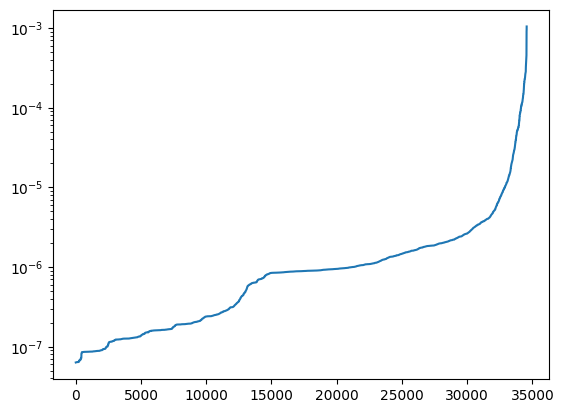

In [85]:
plt.semilogy(sorted(df2['$\epsilon$']))
plt.show()

## Test `KmatrixI_jit`

In [86]:
h_ss = np.array([20., 100.])

In [87]:
values1 = list(itertools.product(
    omegas, sj_nm, rk_nm,
    epsilon_ss, sigmas, rhos,
    epsilon_ds, h_ss))

len(values1)

34560

In [88]:
print("estimated run time = {:0.1f} min".format(len(values1) * 4.5 / 36288))

estimated run time = 4.3 min


Uncomment the line below to do a dry run on a small subset of the variables.

In [89]:
# values1 = values1[0:101]

Running 100 variables takes 0.899 seconds (user time). \
Based in this small run, compute how long running 34560 variables should take. 

In [90]:
print("estimated run time = {:0.1f} min".format(36288 * 0.899 / (60 * 100)))

estimated run time = 5.4 min


In [91]:
%%time

Kn1     = np.zeros((len(values1),3), dtype=np.complex128)
Kn1_jit = np.zeros((len(values1),3), dtype=np.complex128)

for index, (omega, sj, rk, epsilon_s, sigma, rho, epsilon_d, h_s) in enumerate(values1):

    sample1 = SampleModel1(
        cantilever = cantilever,
        h_s = ureg.Quantity(h_s, 'nm'),
        epsilon_s = ureg.Quantity(epsilon_s, ''),
        epsilon_d = ureg.Quantity(epsilon_d, ''),
        sigma = ureg.Quantity(sigma, 'S/m'),
        rho = ureg.Quantity(rho, '1/m^3'),
        z_r = ureg.Quantity(1, 'nm'))

    sample1_jit = SampleModel1Jit(**sample1.args())

    params1 = {
        'integrand': integrand1jit,
        'sample': sample1_jit,
        'omega': omega,
        'location1': 1.0e-9 * sj,
        'location2': 1.0e-9 * rk
    }
    
    K0a, K1a, K2a = K_jit(**params1)
    Kn1[index] = np.array([K0a, K1a, K2a])

    args = {
        "omega": omega,
        "omega0": sample1_jit.omega0,
        "kD": sample1_jit.kD,
        "hs": sample1_jit.h_s, 
        "es": sample1_jit.epsilon_s,
        "ed": sample1_jit.epsilon_d,
        "sj": np.array([sj]),
        "rk": np.array([rk]),
        "j0s": j0s,
        "an": an}

    K0b, K1b, K2b = KmatrixI_jit(**args)
    Kn1_jit[index] = np.array([K0b[0][0], K1b[0][0], K2b[0][0]])

CPU times: user 6min 33s, sys: 7.1 s, total: 6min 41s
Wall time: 7min 22s


In [92]:
Kn1_errors = np.zeros((len(values1),3), dtype=np.complex128)
epsilon1 = np.zeros((len(values1)), dtype=np.float64)
c = np.zeros(3, dtype=np.complex128)

for index1, (a,b) in enumerate(zip(Kn1, Kn1_jit)):
    
    for index2 in [0, 1, 2]:
    
        c[index2] = complex(1,0) * (a[index2].real - b[index2].real) / a[index2].real \
                  + complex(0,1) * (a[index2].imag - b[index2].imag) / a[index2].imag
            
    Kn1_errors[index1] = c
    
    epsilon1[index1] = np.sqrt(np.real(np.sum(c * np.conj(c))))

In [93]:
df1 = pd.DataFrame(
    values1, 
    columns=['$\omega$ [Hz]', '$s_j$ [nm]', '$r_k$ [nm]', 
             '$\epsilon_{\mathrm{s}}$', '$\sigma$ [S/m]', '$\rho$ [1/m$^3$]',
             '$\epsilon_{\mathrm{d}}$', '$h_{\mathrm{s}}$ [nm]'])
    
df1['$\epsilon$'] = epsilon1

In [94]:
pd.options.display.float_format = '{:,.1e}'.format
df1.sort_values(by='$\epsilon$', ascending=False)

,$\omega$ [Hz],$s_j$ [nm],$r_k$ [nm],$\epsilon_{\mathrm{s}}$,$\sigma$ [S/m],$\rho$ [1/m$^3$],$\epsilon_{\mathrm{d}}$,$h_{\mathrm{s}}$ [nm],$\epsilon$
25938,6.3e+05,"[0.0, 0.0, 50.0]","[0.0, 0.0, 30.0]",3.0e+00+0.0e+00j,1.0e-08,1.0e+19,1.0e+02+0.0e+00j,2.0e+01,4.0e-03
14402,6.3e+03,"[0.0, 0.0, 50.0]","[0.0, 0.0, 30.0]",3.0e+00+0.0e+00j,1.0e-10,1.0e+19,1.0e+02+0.0e+00j,2.0e+01,4.0e-03
14562,6.3e+03,"[0.0, 0.0, 50.0]","[0.0, 0.0, 30.0]",1.0e+01+0.0e+00j,1.0e-10,1.0e+19,1.0e+02+0.0e+00j,2.0e+01,3.7e-03
26098,6.3e+05,"[0.0, 0.0, 50.0]","[0.0, 0.0, 30.0]",1.0e+01+0.0e+00j,1.0e-08,1.0e+19,1.0e+02+0.0e+00j,2.0e+01,3.7e-03
14582,6.3e+03,"[0.0, 0.0, 50.0]","[0.0, 0.0, 30.0]",1.0e+01+0.0e+00j,1.0e-08,1.0e+21,1.0e+02+0.0e+00j,2.0e+01,3.5e-03
...,...,...,...,...,...,...,...,...,...
13976,6.3e+03,"[0.0, 0.0, 50.0]","[0.0, 20.0, 20.0]",3.0e+00+0.0e+00j,1.0e-04,1.0e+23,3.0e+00+0.0e+00j,2.0e+01,5.4e-08
8216,6.3e+02,"[0.0, 0.0, 50.0]","[0.0, 20.0, 20.0]",3.0e+00+0.0e+00j,1.0e-04,1.0e+23,3.0e+00+0.0e+00j,2.0e+01,5.4e-08
19752,6.3e+04,"[0.0, 0.0, 50.0]","[0.0, 20.0, 20.0]",3.0e+00+0.0e+00j,1.0e-02,1.0e+23,3.0e+00+0.0e+00j,2.0e+01,5.4e-08
2456,6.3e+01,"[0.0, 0.0, 50.0]","[0.0, 20.0, 20.0]",3.0e+00+0.0e+00j,1.0e-04,1.0e+23,3.0e+00+0.0e+00j,2.0e+01,5.4e-08


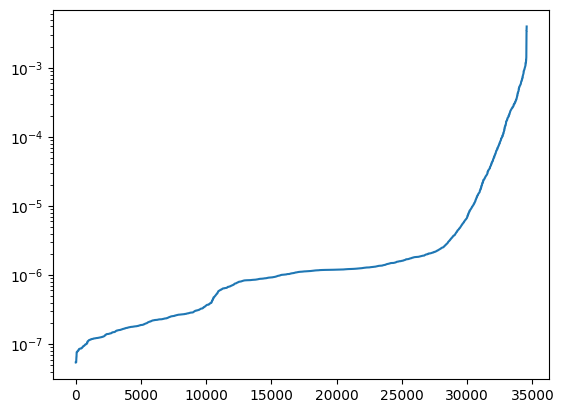

In [95]:
plt.semilogy(sorted(df1['$\epsilon$']))
plt.show()

# Results

Let's perform some run-time-per-value computations:

In [100]:
(6 * 60 + 33) * 1000 / 34560

11.371527777777779

In [101]:
(5 * 60 + 16) * 1000 / 34560

9.143518518518519

The following table summarizes our unit tests. \
The calculations were carried out with `BREAKPOINTS = 10`.  \
In the table, "run time" refers to user CPU time.

| sample type | values varied | no. values | run time | run time per value | $\epsilon_{\mathrm{max}}$ | 
| --- | --- | --- | --- | --- | --- |
| I | $\boldsymbol{s}_j$, $\boldsymbol{r}_k$, $\omega$, $\epsilon_{\mathrm{s}}$, $\rho$, $\sigma$,  $\epsilon_{\mathrm{d}}$,  $h_{\mathrm{s}}$ | 34560 | 6m 33s|  11.4 ms | 0.40% |
| II | $\boldsymbol{s}_j$, $\boldsymbol{r}_k$, $\omega$, $\epsilon_{\mathrm{s}}$, $\rho$, $\sigma$, $\epsilon_{\mathrm{d}}$,  $h_{\mathrm{d}}$ | 34560 | 5m 16s |  9.1 ms | 0.10% |
| III | $\boldsymbol{s}_j$, $\boldsymbol{r}_k$, $\omega$, $\epsilon_{\mathrm{s}}$, $\rho$, $\sigma$ | 36288	| 3m 15s | 5.4 ms | 0.04% | 



# Discussion

Using 10 breakpoints in the computation of the integrals, the root-mean-square error in the $K_n$ integrals is worse for Type I and Type II samples than for Type III samples, but is nevertheless below 0.5%.  The run time for Type I and II samples is a factor of two longer than for Type III samples. We conclude that the accuracy and run time of the Type I and Type II sample $K_n$ calculations are sufficiently good to warrant analyzing data.

Next step: Add Type I and Type II sample calculations to `twodimCobject` in `dissipation13e.py`.

::: {.content-hidden when-format="html"}

# Formatting notes

The header at the top of this file is for creating a nicely-formatted `.html` document using the program `quarto` ([link](https://quarto.org/)).  To create nicely-formated `.html`versions of this notebook, run `quarto` from the command line as follows

    quarto render dissipation-theory--Study-64.ipynb && open dissipation-theory--Study-64.html
    
:::